WRITE A DESCRIPTION

In [454]:
#! pip install simpy
import simpy
#! pip install numpy
import numpy as np
#! pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
from IPython.display import display

In [455]:
class Scheduler:

    def __init__(self, environment, type):

        self.environment = environment
        self.type = type
        self.vehicles = []
        self.all_completed_tasks = []
        self.task_id_counter = 0
        self.current_task = None
        
        if type == "RANDOM":
            self.environment.process(self.process_randomly(self.environment))
        elif type == "FIFO":
            self.environment.process(self.process_fifo(self.environment))
        elif type == "LIFO":
            self.environment.process(self.process_lifo(self.environment))
        elif type == "EDF":
            self.environment.process(self.process_edf(self.environment))
        elif type == "EDF-PRE":
            self.environment.process(self.process_edf_preemptive(self.environment))
        else:
            print("Incorrect scheduling type... choose from: RANDOM, FIFO, LIFO or EDF")

    def idle_vehicle_exists(self):
        return any(vehicle.idle for vehicle in self.vehicles)
    
    def get_idle_vehicles(self):
        return [vehicle for vehicle in self.vehicles if vehicle.idle]

    def get_departed_vehicles(self):
        return [vehicle for vehicle in self.vehicles if not vehicle.inROI]

    def pending_task_exists(self):
        return any(vehicle.pending_tasks for vehicle in self.vehicles)
    
    def get_pending_tasks(self):
        return [task for vehicle in self.vehicles for task in vehicle.pending_tasks]
    
    def all_tasks(self):
        return [task for vehicle in self.vehicles for task in vehicle.assigned_tasks]

    def completed_tasks(self):
        return [task for vehicle in self.vehicles for task in vehicle.completed_tasks]
    
    def unfinished_tasks(self):
        incomplete = []
        for vehicle in self.vehicles:
            for task in vehicle.assigned_tasks:
                if task not in self.all_completed_tasks:
                    incomplete.append(task)
        return incomplete

    def mean_tasks_completed_per_vehicle(self):
        sum = 0

        for vehicle in self.vehicles:
            if (vehicle.assigned_tasks):
                sum += len(vehicle.completed_tasks)/len(vehicle.assigned_tasks)

        mean = (sum/len(self.vehicles)) * 100
        return mean

    def time_spent_processing(self):
        result = []

        for v in self.vehicles:

            v_processing_time = 0
            incomplete_tasks = [t for t in v.assigned_tasks if t not in v.completed_tasks]
            #processing time of all incomplete tasks
            for t in incomplete_tasks:
                v_processing_time += t.time_spent_processing
            #processing time of all completed tasks
            for t in v.completed_tasks:
                v_processing_time += t.duration
                
            result.append(v_processing_time)    
        #should hold the time spent processing for each vehicle   
        return result 

    def process_randomly(self, environment):
        while True:
            print("time:", environment.now)
            while self.pending_task_exists() and self.idle_vehicle_exists():
                selected_vehicle = random.choice(self.get_idle_vehicles())
                selected_task = random.choice(self.get_pending_tasks())
                print(f"At t={self.environment.now} Task {selected_task.id} -> Vehicle {selected_vehicle.id}")

                selected_vehicle.idle = False
                selected_task.vehicle.pending_tasks.remove(selected_task)
                self.environment.process(selected_vehicle.process_task(selected_task))

            print(f"timing out to next time unit ({environment.now + 1})")
            yield environment.timeout(1)

    def process_fifo(self, environment):

         while True:
            print("time:", environment.now)
            while self.pending_task_exists() and self.idle_vehicle_exists():
                    selected_vehicle = random.choice(self.get_idle_vehicles())
                    selected_task = min(self.get_pending_tasks(), key=lambda task: task.id)
                    print(f"At t={self.environment.now} Task {selected_task.id} -> Vehicle {selected_vehicle.id}")

                    selected_vehicle.idle = False
                    selected_task.vehicle.pending_tasks.remove(selected_task)
                    self.environment.process(selected_vehicle.process_task(selected_task))

            yield environment.timeout(1)

    def process_lifo(self, environment):
        while True:
            print("time:", environment.now)
            while self.pending_task_exists() and self.idle_vehicle_exists():
                    selected_vehicle = random.choice(self.get_idle_vehicles())
                    selected_task = max(self.get_pending_tasks(), key=lambda task: task.id)
                    print(f"At t={self.environment.now} Task {selected_task.id} -> Vehicle {selected_vehicle.id}")

                    selected_vehicle.idle = False
                    selected_task.vehicle.pending_tasks.remove(selected_task)

                    self.environment.process(selected_vehicle.process_task(selected_task))

            yield environment.timeout(1)


    def process_edf(self, environment):
        while True:
            print("time:", environment.now)
            while self.pending_task_exists() and self.idle_vehicle_exists():
                    selected_vehicle = random.choice(self.get_idle_vehicles())
                    selected_task = min(self.get_pending_tasks(), key=lambda task: task.priority)
                    print(f"At t={self.environment.now} Task {selected_task.id} -> Vehicle {selected_vehicle.id}")

                    selected_vehicle.idle = False
                    selected_task.vehicle.pending_tasks.remove(selected_task)

                    self.environment.process(selected_vehicle.process_task(selected_task))

            yield environment.timeout(1)

    def process_edf_preemptive(self, environment):
        while True:
            print("time:", environment.now)

            if environment.now == 1:
                      t5 = Task(id = 5, priority = -1, duration= 1, vehicle= v1, environment=intersection)

            while self.pending_task_exists():
                selected_task = min(self.get_pending_tasks(), key=lambda task: task.priority)
                selected_vehicle = None

                if self.idle_vehicle_exists():
                    selected_vehicle = random.choice(self.get_idle_vehicles())
                    print(f"At t={self.environment.now} Task {selected_task.id} -> Vehicle {selected_vehicle.id}")
                    selected_vehicle.idle = False
                    selected_task.vehicle.pending_tasks.remove(selected_task)
                    #set current task and process
                    selected_vehicle.current_task = selected_task
                    selected_vehicle.current_process = self.environment.process(selected_vehicle.process_task(selected_task))
                else:
                    preemptive_vehicle = None
                    
                    for vehicle in self.vehicles:
                        if vehicle.current_task.priority > selected_task.priority:
                            if not any(other_vehicle.current_task.priority > vehicle.current_task.priority for other_vehicle in self.vehicles):
                                preemptive_vehicle = vehicle
                                break
                    
                    if preemptive_vehicle:
                        preemptive_task = preemptive_vehicle.current_task
                        print(f"At t={self.environment.now}, preempting task {preemptive_task} on vehicle {preemptive_vehicle.id}")
                        preemptive_vehicle.current_process.interrupt()
                        print(f"At t={self.environment.now} Task {selected_task.id} -> Vehicle {preemptive_vehicle.id}")
                        preemptive_vehicle.idle = False
                        selected_task.vehicle.pending_tasks.remove(selected_task)
                        preemptive_vehicle.current_task = selected_task
                        preemptive_vehicle.current_process = self.environment.process(preemptive_vehicle.process_task(selected_task))
                    else:
                        break
            
            print("timing out now")
            yield environment.timeout(1)

            
  #  def process_oracle():

In [456]:
class Task:

    def __init__(self, id, priority, duration, vehicle, environment):

        self.id = id
        self.priority = priority
        self.duration = duration
        self.vehicle = vehicle
        self.environment = environment

        self.time_spent_processing = 0
        self.start = None 

        self.vehicle.assigned_tasks.append(self)
        self.vehicle.pending_tasks.append(self)
        self.vehicle.scheduler.task_id_counter += 1

        print(f"At t={self.environment.now} Vehicle {self.vehicle.id} generated task {self}")

    def __str__(self):
        return f"id={self.id}, priority={self.priority}, duration={self.duration}"

In [457]:
class Vehicle:

    def __init__(self, id, environment, lambda_tasks, lambda_dwell_time, scheduler):

        self.id = id
        self.environment = environment
        self.assigned_tasks = []
        self.pending_tasks = []
        self.completed_tasks = []
        self.lambda_tasks = lambda_tasks
        self.lambda_dwell_time = lambda_dwell_time   
        self.scheduler = scheduler

        self.idle = True
        self.inROI = True
        self.current_task = None
        self.current_process = None

        print(f'At t={self.environment.now}, Vehicle {self.id} spawned')
        self.scheduler.vehicles.append(self)

        #schedule departure
        self.environment.process(self.scheduleDeparture(self.environment))
        #start task generator
        #self.environment.process(self.generateTasks())

    def scheduleDeparture(self, environment):
        yield environment.timeout(np.random.poisson(self.lambda_dwell_time))
        self.inROI = False

    def process_task(self, assigned_task):
        try:
            start = self.environment.now
            #print(f"At t={start}, Vehicle {self.id} will begin processing Task: {assigned_task}")
            yield self.environment.timeout(assigned_task.duration- assigned_task.time_spent_processing)
            print(f"AT t={self.environment.now}, Vehicle {self.id} completed Task {assigned_task}")
            self.idle = True
            self.current_task = None
            self.current_process = None
            self.completed_tasks.append(assigned_task)
            self.scheduler.all_completed_tasks.append(assigned_task)

        except simpy.Interrupt:
            assigned_task.time_spent_processing += self.environment.now - start
            assigned_task.vehicle.pending_tasks.append(assigned_task)
            print(f"TASK {assigned_task.id} INTERRUPTED AT {self.environment.now}, after processing for {assigned_task.time_spent_processing}, leaving {assigned_task.duration - assigned_task.time_spent_processing} time units to be processed")

    def generateTasks(self):
        while self.inROI:
            yield self.environment.timeout(np.random.poisson(self.lambda_tasks)) 
            new_Task = Task(self.scheduler.task_id_counter, random.randint(0, 5) , random.randint(1, 5) , self, self.environment)
            print(f'At t={self.environment.now}, Vehicle {self.id} generated a new Task {new_Task}')

        print(f"At t={self.environment.now}, Vehicle {self.id} left the intersection and stopped generating tasks")

In [458]:
class VehicleGenerator:

    def __init__(self, lambda_vehicles, lambda_tasks, lambda_dwell_time, environment, scheduler):

        self.lambda_vehicles = lambda_vehicles
        self.lambda_tasks = lambda_tasks
        self.lambda_dwell_time = lambda_dwell_time
        self.environment = environment
        self.scheduler = scheduler
        
    def generateVehicles(self, environment):
        while True:
            timeout = np.random.poisson(self.lambda_vehicles)
            yield environment.timeout(timeout)
            Vehicle(len(self.scheduler.vehicles), environment, self.lambda_tasks, self.lambda_dwell_time, self.scheduler)

In [462]:
simulation_data = pd.DataFrame(columns=['scheduling type', 'total vehicles generated',
                                        'vehicles present', 'vehicles departed',
                                        'total tasks generated', 'total tasks completed', 
                                        'total tasks completed percentage', 
                                        'avg. tasks completed per vehicle', 'incomplete tasks',
                                        'vehicle processing times', 'mean vehicle processing times'
                                        ])
exploded_data = None

#run simulation once for each scheduling type
def run_sim(sim_seed, scheduling_type, poisson_vehicles, poisson_tasks, poisson_dwell_time, sim_end_time):

   global simulation_data
   global exploded_data
   index = 0
   
   for type in scheduling_type:

      random.seed(sim_seed)
      np.random.seed(sim_seed)
      
      #setup simulation 
      global intersection
      intersection = simpy.Environment()
      scheduler = Scheduler(intersection, type)
      #vehicle_generator = VehicleGenerator(poisson_vehicles, poisson_tasks, poisson_dwell_time, intersection, scheduler)
      #intersection.process(vehicle_generator.generateVehicles(intersection))
      print(f"{'='*50}\nSCHEDULER: {scheduler.type}")

      global v1,v2
      v1 = Vehicle(id=1, environment= intersection, lambda_tasks= poisson_tasks, lambda_dwell_time= poisson_dwell_time, scheduler= scheduler)
      #v2 = Vehicle(id=2, environment= intersection, lambda_tasks= poisson_tasks, lambda_dwell_time= poisson_dwell_time, scheduler= scheduler)

      t1 = Task(id = 1, priority = 1, duration= 2, vehicle= v1, environment=intersection)
      #t2 = Task(id = 2, priority = 0, duration= 5, vehicle= v1, environment=intersection)
      #t3 = Task(id = 3, priority = 1, duration= 4, vehicle= v2, environment=intersection)
      #t4 = Task(id = 4, priority = 0, duration= 3, vehicle= v2, environment=intersection)
      
      #run simulation
      intersection.run(until = sim_end_time)
      print(f"{scheduler.type} simulation ended at {intersection.now}")

      simulation_data.loc[index] = [type,
                                    len(scheduler.vehicles),
                                    len(scheduler.vehicles)-len(scheduler.get_departed_vehicles()),
                                    len(scheduler.get_departed_vehicles()),
                                    len(scheduler.all_tasks()),
                                    len(scheduler.completed_tasks()),
                                    len(scheduler.completed_tasks())/len(scheduler.all_tasks()) * 100 if len(scheduler.all_tasks()) != 0 else 0,
                                    scheduler.mean_tasks_completed_per_vehicle(),
                                    len(scheduler.unfinished_tasks()),
                                    scheduler.time_spent_processing(),
                                    0 if len(scheduler.vehicles) == 0 else round(sum(scheduler.time_spent_processing())/len(scheduler.vehicles),1)
                                    ]
      index += 1
      
   #dataframe for swarmplot
   exploded_data = simulation_data.explode('vehicle processing times').reset_index(drop=True)[['scheduling type', 'vehicle processing times']]

In [463]:
run_sim(sim_seed = 42, scheduling_type = ['RANDOM', 'FIFO', 'LIFO', 'EDF', 'EDF-PRE'], poisson_vehicles = 0, poisson_tasks = 0, poisson_dwell_time = 15, sim_end_time = 6)
display(simulation_data)

SCHEDULER: RANDOM
At t=0, Vehicle 1 spawned
At t=0 Vehicle 1 generated task id=1, priority=1, duration=2
time: 0
At t=0 Task 1 -> Vehicle 1
timing out to next time unit (1)
time: 1
timing out to next time unit (2)
AT t=2, Vehicle 1 completed Task id=1, priority=1, duration=2
time: 2
timing out to next time unit (3)
time: 3
timing out to next time unit (4)
time: 4
timing out to next time unit (5)
time: 5
timing out to next time unit (6)
RANDOM simulation ended at 6
SCHEDULER: FIFO
At t=0, Vehicle 1 spawned
At t=0 Vehicle 1 generated task id=1, priority=1, duration=2
time: 0
At t=0 Task 1 -> Vehicle 1
time: 1
AT t=2, Vehicle 1 completed Task id=1, priority=1, duration=2
time: 2
time: 3
time: 4
time: 5
FIFO simulation ended at 6
SCHEDULER: LIFO
At t=0, Vehicle 1 spawned
At t=0 Vehicle 1 generated task id=1, priority=1, duration=2
time: 0
At t=0 Task 1 -> Vehicle 1
time: 1
AT t=2, Vehicle 1 completed Task id=1, priority=1, duration=2
time: 2
time: 3
time: 4
time: 5
LIFO simulation ended at

,scheduling type,total vehicles generated,vehicles present,vehicles departed,total tasks generated,total tasks completed,total tasks completed percentage,avg. tasks completed per vehicle,incomplete tasks,vehicle processing times,mean vehicle processing times
0,RANDOM,1,1,0,1,1,100.0,100.0,0,[2],2.0
1,FIFO,1,1,0,1,1,100.0,100.0,0,[2],2.0
2,LIFO,1,1,0,1,1,100.0,100.0,0,[2],2.0
3,EDF,1,1,0,1,1,100.0,100.0,0,[2],2.0
4,EDF-PRE,1,1,0,2,2,100.0,100.0,0,[3],3.0


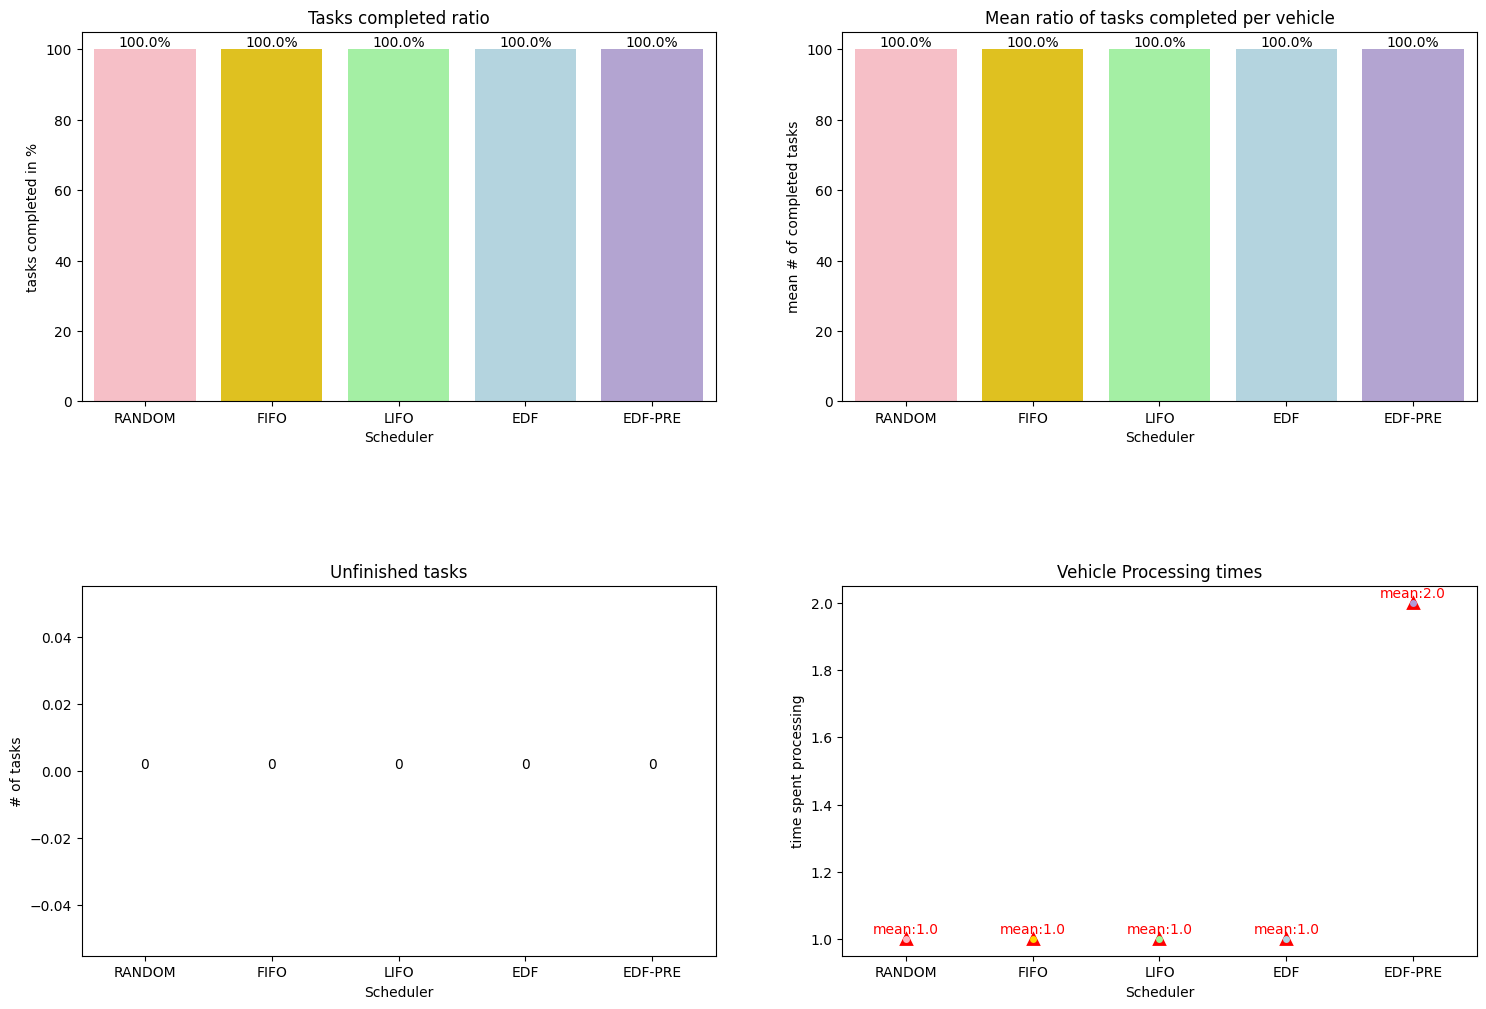

In [461]:
scheduling_type = ['RANDOM', 'FIFO', 'LIFO', 'EDF', 'EDF-PRE']

pastel_colors = ['#FFB6C1', '#FFD700', '#98FB98', '#ADD8E6', '#B19CD9']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.5)


# Plot 1
sns.barplot(x=scheduling_type, y=simulation_data['total tasks completed percentage'], ax=axes[0, 0], hue= scheduling_type, palette=pastel_colors)
axes[0, 0].set_title('Tasks completed ratio')
axes[0, 0].set_xlabel('Scheduler')
axes[0, 0].set_ylabel('tasks completed in %')


# Plot 2
sns.barplot(x=scheduling_type, y=simulation_data['avg. tasks completed per vehicle'], ax=axes[0, 1], hue= scheduling_type, palette=pastel_colors)
axes[0, 1].set_title('Mean ratio of tasks completed per vehicle')
axes[0, 1].set_xlabel('Scheduler')
axes[0, 1].set_ylabel('mean # of completed tasks')

# Plot 3
sns.barplot(x=scheduling_type, y=simulation_data['incomplete tasks'], ax=axes[1, 0], hue= scheduling_type, palette=pastel_colors)
axes[1, 0].set_title('Unfinished tasks')
axes[1, 0].set_xlabel('Scheduler')
axes[1, 0].set_ylabel('# of tasks')

# plot 4
sns.swarmplot(data=exploded_data, x='scheduling type', y='vehicle processing times', ax=axes[1, 1], hue= exploded_data['scheduling type'], palette=pastel_colors)
axes[1,1].set_title('Vehicle Processing times')
axes[1,1].set_xlabel('Scheduler')
axes[1,1].set_ylabel('time spent processing')

#labeling the plots
for index, value in enumerate(simulation_data['total tasks completed percentage']):
    axes[0, 0].text(index, value, f"{round(value,1)}%", ha='center', va='bottom')

for index, value in enumerate(simulation_data['avg. tasks completed per vehicle']):
    axes[0, 1].text(index, value,f"{round(value,1)}%", ha='center', va='bottom')

for index, value in enumerate(simulation_data['incomplete tasks']):
    axes[1, 0].text(index, value, str(value), ha='center', va='bottom')

# Plot mean vehicle processing times
sns.pointplot(data=simulation_data, x='scheduling type', y='mean vehicle processing times', color='red', markers='^', linestyle='none', ax=axes[1, 1])

# Label mean vehicle processing times
for i, row in simulation_data.iterrows():
    axes[1, 1].text(i, row['mean vehicle processing times'] + 0.05, f'mean:{row["mean vehicle processing times"]:.1f}', color='red', ha="center", va="top")

plt.show()